In [829]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict, List, Tuple

In [11]:
# linear transformation
def linear(in_array: np.ndarray, weight: np.ndarray, bias: np.ndarray) -> np.ndarray:
    r"""
    linear transformation: y = xW^T + b

    Args:
        in_array: input array
        weight: input weight
        bias: input bias

    Shapes:
        - Input: (N, in_features)
        - Weight: (out_features, in_features)
        - Bias: (out_features)
        - Output: (N, out_features)
    """

    assert weight.shape[-1] == in_array.shape[-1], "ERR : input and weight dimensions not matched."

    return np.matmul(in_array, weight.T) + bias

In [823]:
# polynomial transformation
def poly(in_array: np.ndarray, weight: np.ndarray, poly_deg: int=3) -> Tuple:
    """
    poly transformation: y = \sum_{i=0}^{n} a_ix^i

    Args:
        in_array: input array
        weight: coefficients in transformation
        poly_deg: the degree of polynomial

    Shapes:
        - Input: (N, in_features)
        - Weight: (depth, )
    """
    poly = PolynomialFeatures(poly_deg)
    base_items = poly.fit_transform(in_array)
    assert base_items.shape[-1] == weight.shape[-1], "shape of weight mismatches with polynomial shape."
    res = np.sum(base_items * weight, axis=1, keepdims=True)

    return res, base_items

def get_poly_dim(num_features: int, poly_deg: int) -> int:
    """test on simple polynomial to check the number of items """
    arr_test = np.zeros([1, num_features])
    poly = PolynomialFeatures(poly_deg)
    return poly.fit_transform(arr_test).shape[-1]


In [34]:
# base class
# TODO: abstract class for regression
class Module(object):
    def __init(self):
        pass

    def __call__(self):
        return

In [905]:
# initializers
def regression_initializer(size: Tuple, cate: str='normal') -> Dict:
    """initialize list with size `length`,default to `normal`

    for more details, check: https://blog.csdn.net/kane7csdn/article/details/108896031
    """
    assert size is not None, "size is None."

    cate_type = cate.lower()
    initial_list = ['normal', 'uniform', 'zeros', 'ones', 'xavier_normal', 'xavier_uniform']
    assert cate_type in initial_list, NotImplemented

    if cate == 'normal':
        return {
            'W': np.random.normal(loc=0., scale=1., size=size),
            'b': np.random.normal(loc=0., scale=1., size=size[0])
        }
    elif cate == 'uniform':
        a = 1. / size[-1]
        return {
            'W': np.random.uniform(low=-a, high=a, size=size),
            'b': np.random.uniform(low=-a, high=a, size=size[0])
        }
    elif cate == 'zeros':
        a = 1. / size[-1]
        return {
            'W': np.zeros(size),
            'b': np.zeros(size[0])
        }
    elif cate == 'ones':
        a = 1. / size[-1]
        return {
            'W': np.ones(size),
            'b': np.ones(size[0])
        }
    elif cate == 'xavier_normal':
        std = np.sqrt(2. / (size[0] + size[-1]))
        return {
            'W': np.random.normal(loc=0., scale=std, size=size),
            'b': np.random.normal(loc=0., scale=std, size=size[0])
        }
    elif cate == 'xavier_uniform':
        a = np.sqrt(6. / (size[0] + size[-1]))
        return {
            'W': np.random.uniform(low=-a, high=a, size=size),
            'b': np.random.uniform(low=-a, high=a, size=size[0])
        }
    else:
        assert NotImplemented

In [318]:
# loss functions
def mean_squared_error(y_pred: np.ndarray, y_std: np.ndarray, n: int):
    """Mean Squared Error, a.k.a MSE"""
    return np.sum((y_pred - y_std)**2) / n

def loss_fn(cate: str='mse'):
    """loss functions"""
    if cate=='mse':
        return mean_squared_error
    else:
        return NotImplemented

In [1039]:
# optimizers
def SGD(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs) -> Dict:
    """Stochastic Gradient Descent"""
    epoch = kwargs['epoch']
    epoch += 1
    return {
        'weight_updated': weight - lr * dw,
        'bias_updated': bias - lr * db,
        'epoch': epoch
    }

def momentum(dw: np.ndarray, db: np.ndarray, lr: int,
             weight: np.ndarray, bias: np.ndarray,
             **kwargs) -> Dict:
    """Momentum Gradient Descent"""

    prev_mm_w = kwargs['prev_mm_w']
    prev_mm_b = kwargs['prev_mm_b']
    epoch = kwargs['epoch']

    beta = 0.9
    cur_mm_w = beta * prev_mm_w - (1 - beta) * dw
    cur_mm_b = beta * prev_mm_b - (1 - beta) * db
    cur_mm_w /= (1 - beta**epoch)
    cur_mm_b /= (1 - beta**epoch)
    epoch += 1

    return {
        'weight_updated': weight - lr * cur_mm_w,
        'bias_updated' : bias - lr * cur_mm_b,
        'prev_mm_w' : cur_mm_w,
        'prev_mm_b' : cur_mm_b,
        'epoch': epoch
    }

def RMSprop(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs):
    """RMSprop Gradient Descent"""
    prev_s_w = kwargs['prev_s_w']
    prev_s_b = kwargs['prev_s_b']
    epoch = kwargs['epoch']

    beta = 0.9
    epsilon = 1e-6
    cur_s_w = beta * prev_s_w + (1 - beta) * dw**2
    cur_s_b = beta * prev_s_b + (1 - beta) * db**2
    cur_s_w /= (1 - beta**epoch)
    cur_s_b /= (1-  beta**epoch)

    return {
        'weight_updated': weight - lr / np.sqrt(cur_s_w + epsilon) * dw,
        'bias_updated' : bias - lr / np.sqrt(cur_s_b + epsilon) * db,
        'prev_s_w': cur_s_w,
        'prev_s_b': cur_s_b,
        'epoch': epoch
    }

def Adam(dw: np.ndarray, db: np.ndarray, lr: int,
        weight: np.ndarray, bias: np.ndarray,
        **kwargs):
    """Adam Gradient Descent"""
    prev_mm_w = kwargs['prev_mm_w']
    prev_mm_b = kwargs['prev_mm_b']
    prev_s_w = kwargs['prev_s_w']
    prev_s_b = kwargs['prev_s_b']
    epoch = kwargs['epoch']

    beta = 0.9
    epsilon = 1e-6
    cur_mm_w = beta * prev_mm_w - (1 - beta) * dw
    cur_mm_b = beta * prev_mm_b - (1 - beta) * db
    cur_mm_w /= (1 - beta**epoch)
    cur_mm_b /= (1 - beta**epoch)
    cur_s_w = beta * prev_s_w + (1 - beta) * dw**2
    cur_s_b = beta * prev_s_b + (1 - beta) * db**2
    cur_s_w /= (1 - beta**epoch)
    cur_s_b /= (1-  beta**epoch)

    return {
        'weight_updated': weight - lr * cur_mm_w / (np.sqrt(cur_s_w) + epsilon) * dw,
        'bias_updated' : bias - lr * cur_mm_b / (np.sqrt(cur_s_b) + epsilon) * db,
        'prev_mm_w' : cur_mm_w,
        'prev_mm_b' : cur_mm_b,
        'prev_s_w': cur_s_w,
        'prev_s_b': cur_s_b,
        'epoch': epoch
    }

def optimizer(cate: str='SGD'):
    """optimizers"""
    assert cate is not None, "Optimizer not selected"
    cate_type = cate.lower()
    optimizer_list = ['sgd', 'momentum', 'rmsprop', 'adam']
    assert  cate_type in optimizer_list, NotImplemented

    if cate_type == 'sgd':
        return SGD
    elif cate_type == 'momentum':
        return momentum
    elif cate_type == 'rmsprop':
        return RMSprop
    elif cate_type == 'adam':
        return Adam
    else:
        return NotImplemented


In [1033]:
def get_optional_args(optimizer_type: str='SGD') -> Dict:
    """fill in optional arguments for different optimizers"""
    assert optimizer_type is not None, "Optimizer not selected"
    cate_type = optimizer_type.lower()
    optimizer_list = ['sgd', 'momentum', 'rmsprop', 'adam']
    assert  cate_type in optimizer_list, NotImplemented

    optional_args = {}
    optional_args['epoch'] = 1
    if optimizer_type == 'momentum':
        optional_args['prev_mm_w'] = 0
        optional_args['prev_mm_b'] = 0
    elif optimizer_type == 'rmsprop':
        optional_args['prev_s_w'] = 0
        optional_args['prev_s_b'] = 0
    elif optimizer_type == 'adam':
        optional_args['prev_mm_w'] = 0
        optional_args['prev_mm_b'] = 0
        optional_args['prev_s_w'] = 0
        optional_args['prev_s_b'] = 0
    return optional_args

In [919]:
class LinearRegression(Module):
    """
    linear transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.001,
                 optimizer_type: str='SGD'):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1

        self.lr = lr
        self.optimizer = optimizer(optimizer_type)
        self.optional_args = get_optional_args(optimizer_type)
        self.initial = regression_initializer((self.out_features,
                                               self.in_features),
                                               initializer_type)
        self.weight = self.initial['W']
        self.bias = self.initial['b']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0
        self.db = 0

        self.y_pred = np.array([])
        self.cache = {}

    def forward(self) -> np.ndarray:
        self.y_pred = linear(self.in_array, self.weight, self.bias)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (1. / self.batch_size) * np.sum(self.in_array * diff, axis=0)
        self.db = (1. / self.batch_size) * np.sum(diff)

    def step(self):
        param_updated = self.optimizer(self.dw, self.db, self.lr, self.weight, self.bias, **self.optional_args)
        self.weight = param_updated['weight_updated']
        self.bias = param_updated['bias_updated']

        for opt_arg in self.optional_args.keys():
            self.optional_args[opt_arg] = param_updated[opt_arg]

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Linear Regression Model"


In [932]:
class PolyRegression(Module):
    """
    Polynomial transformations: y = xW^T + b,
    initializer default to `normal`,


    Args:
        in_array: feature array

    Shapes:
        in_array: (N, in_features)
        out_array: (N, )
    """
    def __init__(self, in_array: np.ndarray,
                 initializer_type: str='normal',
                 loss_fn_type: str='mse',
                 lr: float=0.00001,
                 optimizer_type: str='SGD',
                 poly_deg: int=3):
        # NOTICE: check in_array for batch case
        super().__init__()
        self.in_array = in_array
        self.batch_size = in_array.shape[0]
        self.in_features = in_array.shape[-1]
        self.out_features = 1
        self.optional_args = get_optional_args(optimizer_type)

        self.lr = lr
        self.poly_deg = poly_deg
        self.optimizer = optimizer(optimizer_type)
        # for initialization in the view of math, check out : https://math.stackexchange.com/questions/2928712/number-of-elements-in-polynomial-of-degree-n-and-m-variables
        self.weight_dim = get_poly_dim(self.in_features, poly_deg)
        self.initial = regression_initializer((self.out_features,
                                               self.weight_dim),
                                               initializer_type)
        self.weight = self.initial['W']

        self.loss_fn = loss_fn(loss_fn_type)
        self.loss = 99999

        self.dw = 0

        self.cache_poly_matrix = np.array([])
        self.y_pred = np.array([])

    def forward(self) -> np.ndarray:
        self.y_pred, self.cache_poly_matrix = poly(self.in_array,
                                                   self.weight,
                                                   self.poly_deg)
        return self.y_pred

    def loss_reg(self, y_std):
        self.loss = self.loss_fn(self.y_pred, y_std, self.batch_size)

    def backward(self, y_std):
        diff = self.y_pred - y_std
        self.dw = (2. / self.batch_size) * np.sum(diff * self.cache_poly_matrix, axis=0)

    def step(self):
        param_updated = self.optimizer(self.dw, 0, self.lr, self.weight, 0, **self.optional_args)
        self.weight = param_updated['weight_updated']

        for opt_arg in self.optional_args.keys():
            self.optional_args[opt_arg] = param_updated[opt_arg]

    def print_params(self):
        # print(f"weight: {self.weight} \nbias: {self.bias} \nloss: {self.loss}")
        print(f"loss: {self.loss}")

    def __name__(self):
        return "Polynomial Regression Model"


In [908]:
def training(model, labels, epochs: int=100, isLinear: int=False) -> Dict:
    """Training loop

    Args:
        model: regression model
        labels: target labels
        epochs: training epochs
        isLinear: Linear Regression or not (bias in result)
    """
    result = {}

    for epoch in range(epochs):
        model.forward()
        model.backward(labels)
        model.loss_reg(labels)
        model.step()
        print(f"Epoch: {epoch}", end=" ")
        model.print_params()

    result['name'] = model.__class__.__name__
    result['weight'] = model.weight
    if isLinear:
        result['bias'] = model.bias
    result['loss'] = model.loss
    return result

## Synthetic Test

### Linear

In [687]:
def synthetic_linear_data(w,b,num_examples):
    """ 生成 y = Xw + b + 噪声。"""
    X = np.random.normal(0,1,(num_examples,len(w[0])))
    y = np.matmul(X,w.T) + b
    y += np.random.normal(0,0.01,y.shape) # 均值为0，方差为1
    return X, y.reshape((-1,1))

true_w = np.array([[1.2, 3, 5, 6, 7]])
true_b = [[4.2]]
features, labels = synthetic_linear_data(true_w,true_b,1000)

In [1059]:
linear_reg = LinearRegression(features, lr=0.01, optimizer_type='sgd')
training_res = training(linear_reg, labels, epochs=1000, isLinear=True)

{'epoch': 2}
Epoch: 0 loss: 145.4814997823163
{'epoch': 3}
Epoch: 1 loss: 142.80936088720398
{'epoch': 4}
Epoch: 2 loss: 140.18657783601248
{'epoch': 5}
Epoch: 3 loss: 137.61223371333205
{'epoch': 6}
Epoch: 4 loss: 135.08542873900936
{'epoch': 7}
Epoch: 5 loss: 132.6052799459991
{'epoch': 8}
Epoch: 6 loss: 130.1709208643083
{'epoch': 9}
Epoch: 7 loss: 127.78150121091815
{'epoch': 10}
Epoch: 8 loss: 125.43618658556879
{'epoch': 11}
Epoch: 9 loss: 123.13415817229613
{'epoch': 12}
Epoch: 10 loss: 120.87461244661102
{'epoch': 13}
Epoch: 11 loss: 118.65676088821378
{'epoch': 14}
Epoch: 12 loss: 116.47982969913826
{'epoch': 15}
Epoch: 13 loss: 114.34305952722265
{'epoch': 16}
Epoch: 14 loss: 112.24570519480586
{'epoch': 17}
Epoch: 15 loss: 110.18703543254962
{'epoch': 18}
Epoch: 16 loss: 108.1663326182893
{'epoch': 19}
Epoch: 17 loss: 106.18289252081789
{'epoch': 20}
Epoch: 18 loss: 104.236024048509
{'epoch': 21}
Epoch: 19 loss: 102.32504900268744
{'epoch': 22}
Epoch: 20 loss: 100.4493018356

In [1060]:
training_res

{'name': 'LinearRegression',
 'weight': array([[1.20020099, 2.99961476, 5.00006356, 5.99924317, 6.99832937]]),
 'bias': array([4.19909512]),
 'loss': 9.927574082450759e-05}

### Non-linear

In [868]:
def synthetic_poly_data():
    x = np.linspace(0, 1, 100)
    y = np.sin(5 * x) + 0.1 + np.random.randn(len(x)) * 0.1
    return x, y

syn_poly_data = synthetic_poly_data()
poly_features = syn_poly_data[0][:, np.newaxis]
poly_labels = syn_poly_data[1][:, np.newaxis]

In [1006]:
poly_reg = PolyRegression(poly_features, lr=0.1, poly_deg=10, optimizer_type='SGD')
poly_training_res = training(poly_reg, poly_labels, epochs=10000)

{}
Epoch: 0 loss: 0.3092685096292266
{}
Epoch: 1 loss: 0.21298975561281783
{}
Epoch: 2 loss: 0.17057515678055427
{}
Epoch: 3 loss: 0.15065094417690175
{}
Epoch: 4 loss: 0.14029819495611362
{}
Epoch: 5 loss: 0.13417080208816232
{}
Epoch: 6 loss: 0.13003393997069432
{}
Epoch: 7 loss: 0.12693432160545984
{}
Epoch: 8 loss: 0.12444931962054814
{}
Epoch: 9 loss: 0.1223784199859704
{}
Epoch: 10 loss: 0.12061609010949875
{}
Epoch: 11 loss: 0.11909910070896396
{}
Epoch: 12 loss: 0.11778444688946171
{}
Epoch: 13 loss: 0.11663988155821363
{}
Epoch: 14 loss: 0.11563967859950326
{}
Epoch: 15 loss: 0.1147625911547766
{}
Epoch: 16 loss: 0.11399075372381548
{}
Epoch: 17 loss: 0.11330900884170582
{}
Epoch: 18 loss: 0.11270444005302077
{}
Epoch: 19 loss: 0.11216601705180108
{}
Epoch: 20 loss: 0.11168431041500085
{}
Epoch: 21 loss: 0.1112512550665686
{}
Epoch: 22 loss: 0.11085995100085749
{}
Epoch: 23 loss: 0.1105044940654371
{}
Epoch: 24 loss: 0.11017983171513693
{}
Epoch: 25 loss: 0.10988163982356487
{

In [955]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[ 0.43838841,  0.93282978, -0.03721371, -0.55448532, -0.87618965,
          1.30919236, -0.35084352, -0.88119349, -0.67633392, -0.94919472,
          0.44507255]]),
 'loss': 0.3608704285380437}

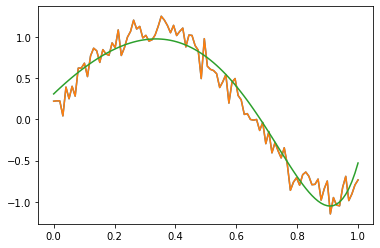

In [1007]:
# poly_training_res
plt.plot(poly_features, poly_labels)

def getY_Hat(x, theta):
    # 根据 theta 作为系数，生成多项式函数
    f = np.poly1d(theta)
    return f(x)

plt.plot(poly_features, poly_labels)
plt.plot(poly_features, getY_Hat(poly_features, np.flip(poly_training_res['weight'][0])))

## Authentic Dataset

In [889]:
sheet = pd.read_csv('output_9291044.csv')
sheet

,index,a,e,i,om,w,q,ad,data_arc,n_obs_used,diameter,n,per,ma
0,0,-0.029846,-0.895611,0.035828,-0.871575,-1.045872,0.302371,-0.085269,-0.023760,0.548671,939.400,-0.100997,-0.010812,-1.022562
1,1,-0.027679,1.093829,3.582539,0.031665,1.237434,-0.520651,0.063683,10.280279,13.113797,545.000,-0.107698,-0.010489,-1.193462
2,2,-0.095528,1.436801,0.386203,0.000245,0.639594,-0.812286,0.044314,10.339673,10.788041,246.596,0.111949,-0.020501,-1.433030
3,3,-0.297618,-0.731735,-0.469255,-0.642731,-0.301053,-0.485692,-0.226383,2.486040,14.514957,525.400,0.912062,-0.049169,-0.843764
4,4,-0.157850,0.587956,-0.728912,-0.275048,1.707118,-0.620504,-0.055395,8.850443,3.760430,106.699,0.333305,-0.029528,0.959753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137631,797860,0.234191,0.175758,2.450501,1.355319,-1.565887,0.511487,0.155093,-1.070295,-1.048818,3.793,-0.791726,0.029889,-0.175197
137632,798077,-0.174819,-0.894811,0.182010,0.744511,-0.114080,-0.093109,-0.167225,-0.920349,-1.077345,2.696,0.397162,-0.031957,-0.365503
137633,798189,0.217787,0.967786,1.114461,-0.310050,-0.009712,0.096293,0.211838,-0.994673,-1.053853,2.917,-0.755178,0.027281,-0.082262
137634,799752,0.155458,1.830068,0.600955,1.694918,1.551910,-0.442448,0.242311,-1.097071,-1.087413,3.271,-0.609446,0.017466,-0.071639


In [890]:
sheet.drop('index', axis=1, inplace=True)
label = sheet['diameter']
dia_dropped = sheet.drop('diameter', axis=1)
feature = dia_dropped

# labels & features
label_a = np.array(label)[:1000][:, np.newaxis]
feature_a = np.array(feature)[:1000]

(1000, 1)


## Linear Model

In [765]:
linear_reg_asteroids = LinearRegression(feature_a, lr=0.001)
training_res = training(linear_reg_asteroids, 100, label_a)

Epoch: 0 loss: 8217.379890666087
Epoch: 1 loss: 7790.131723849973
Epoch: 2 loss: 7400.483953428045
Epoch: 3 loss: 7045.118482373708
Epoch: 4 loss: 6721.010045089201
Epoch: 5 loss: 6425.400364150609
Epoch: 6 loss: 6155.774587798047
Epoch: 7 loss: 5909.839806888393
Epoch: 8 loss: 5685.505467791725
Epoch: 9 loss: 5480.865513908709
Epoch: 10 loss: 5294.182103252941
Epoch: 11 loss: 5123.870763005737
Epoch: 12 loss: 4968.486854226227
Epoch: 13 loss: 4826.713231091606
Epoch: 14 loss: 4697.348989246638
Epoch: 15 loss: 4579.29920714525
Epoch: 16 loss: 4471.565592749657
Epoch: 17 loss: 4373.237955686496
Epoch: 18 loss: 4283.486432010897
Epoch: 19 loss: 4201.55439515856
Epoch: 20 loss: 4126.751992527692
Epoch: 21 loss: 4058.450252477078
Epoch: 22 loss: 3996.0757113993336
Epoch: 23 loss: 3939.1055149711447
Epoch: 24 loss: 3887.0629517329403
Epoch: 25 loss: 3839.513380843634
Epoch: 26 loss: 3796.060519223269
Epoch: 27 loss: 3756.3430563665293
Epoch: 28 loss: 3720.031567909168
Epoch: 29 loss: 3686.8

In [740]:
training_res

{'name': 'LinearRegression',
 'weight': array([[ 1.10473113, -0.08566122,  0.79126384, -0.00888531,  0.93087858,
          1.32911977, -0.05107645,  8.52626194,  6.22214325, -2.04837024,
          0.34220255,  1.56961659]]),
 'bias': array([1.30406137]),
 'loss': 271638.75626286486}

In [1030]:
linear_reg_asteroids = LinearRegression(feature_a, lr=0.0000000001, optimizer_type='momentum')
temp_training_res = training(linear_reg_asteroids, label_a, epochs=100)

{'prev_mm_w': array([ 4.57964020e+00, -3.03417313e+00,  1.39712995e+00,  3.15288131e-01,
       -1.80902382e-01,  1.38151201e+01,  2.35337844e+00,  4.09538611e+02,
        2.48714708e+02, -1.85490231e+01,  3.54300828e-01, -2.84650529e+00]), 'prev_mm_b': 69.20379298311053, 'epoch': 2}
Epoch: 0 loss: 8630.607562223531
{'prev_mm_w': array([ 2.41033695e+01, -1.59693323e+01,  7.35331549e+00,  1.65941122e+00,
       -9.52117802e-01,  7.27111584e+01,  1.23862023e+01,  2.15546637e+03,
        1.30902478e+03, -9.76264372e+01,  1.86474120e+00, -1.49816068e+01]), 'prev_mm_b': 364.23048955333417, 'epoch': 3}
Epoch: 1 loss: 8630.60760921373
{'prev_mm_w': array([ 8.17379946e+01, -5.41543039e+01,  2.49361509e+01,  5.62730226e+00,
       -3.22876851e+00,  2.46574002e+02,  4.20033946e+01,  7.30949667e+03,
        4.43909141e+03, -3.31065298e+02,  6.32360575e+00, -5.08047847e+01]), 'prev_mm_b': 1235.1580077375525, 'epoch': 4}
Epoch: 2 loss: 8630.607856530574
{'prev_mm_w': array([ 2.15243266e+02, -1.4260

## Polynomial Model

In [903]:
linear_reg_asteroids = PolyRegression(feature_a, lr=0.00001, poly_deg=3)
poly_training_res = training(linear_reg_asteroids, 100, label_a)

Epoch: 0 loss: 178222.587639222
Epoch: 1 loss: 88730.01901298095
Epoch: 2 loss: 53987.61232418959
Epoch: 3 loss: 38609.07836542431
Epoch: 4 loss: 30551.20019347055
Epoch: 5 loss: 25588.526623732443
Epoch: 6 loss: 22148.339536472882
Epoch: 7 loss: 19582.921276399597
Epoch: 8 loss: 17584.800043798736
Epoch: 9 loss: 15983.921932673256
Epoch: 10 loss: 14673.793679231127
Epoch: 11 loss: 13582.150860973687
Epoch: 12 loss: 12657.693515887122
Epoch: 13 loss: 11863.10574052501
Epoch: 14 loss: 11170.85771164387
Epoch: 15 loss: 10560.440002244752
Epoch: 16 loss: 10016.444324848479
Epoch: 17 loss: 9527.19564527399
Epoch: 18 loss: 9083.764378753292
Epoch: 19 loss: 8679.248364508536
Epoch: 20 loss: 8308.249070816566
Epoch: 21 loss: 7966.488594146638
Epoch: 22 loss: 7650.529058007194
Epoch: 23 loss: 7357.566619521234
Epoch: 24 loss: 7085.279895957351
Epoch: 25 loss: 6831.718122278894
Epoch: 26 loss: 6595.21834237206
Epoch: 27 loss: 6374.343839281177
Epoch: 28 loss: 6167.838122387062
Epoch: 29 loss: 5

In [904]:
poly_training_res

{'name': 'PolyRegression',
 'weight': array([[ 1.86396275e-01,  9.04133238e-01, -1.89977574e-01,
          3.49076381e-01,  9.77994879e-01, -8.41313650e-01,
         -2.31676640e-01,  7.27497721e-01,  1.62331707e+00,
          4.62461347e-01, -6.91186383e-01, -1.20293457e+00,
          9.78932681e-02,  6.01841698e-01,  4.33366787e-01,
          1.33590556e+00,  3.30690326e-03, -1.76938886e+00,
          1.52812501e+00, -3.29851186e-01,  1.45915055e+00,
         -4.90731721e-02,  3.23598252e-01,  3.88547223e-01,
         -1.66678011e+00, -7.30084855e-01, -9.41917958e-01,
         -2.06816921e+00, -1.47127839e+00, -1.77460277e+00,
          1.96987496e+00, -6.82104546e-02,  1.28872863e+00,
          1.29784572e+00, -1.49469514e+00,  1.40897607e+00,
          5.94351286e-01,  1.65946206e+00,  1.57592012e+00,
          1.00607973e+00,  9.01081098e-01,  3.86310325e-01,
          2.15611234e-01,  1.06044101e-01, -2.91116607e-01,
         -1.47473076e+00,  5.66315869e-01,  1.82229459e+00,
   